## make the filament mock observations, but with masking to compare

In [15]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u
from astropy.io import fits

import os
import get_halpha_SB

%matplotlib inline

%run 'load_data.ipynb'
%run 'add_noise.ipynb'
%run 'extract_FOV.ipynb'
%run 'mask_galaxies.ipynb'
%run 'extract_filament.ipynb'

### load data

In [2]:
machine = 'chinook'
plotchecks = True
slicewidth=5.
distance='50Mpc'
resolution=None

In [4]:
data_tuple_5 = loaddata(machine=machine,resolution=resolution,distance=distance,slicewidth=slicewidth)

Resolution is None, finding minimum resolution of the similuation...
The resolution of the raw simulation at 50Mpc is 13.0357429643.
Loading data of slicewidth 5 (after rounding), number of slices is 1
./intermediatedata/data_50Mpc_13arcsec_5slwd.npz exists, loading now...
./intermediatedata/data_50Mpc_13arcsec_5slwd.npz was not saved as a tuple since too large, returning as tuple with 32000,1,13.0357429643 appended.


### cutout section of the array that contains the filament

In [5]:
xystarts = [40.,0.]
size     = [20.,20.]
data_cutout = data_tuple_5[0]
data_cutout = data_cutout[(40./100.*32000):(60./100.*32000),0:(20./100.*32000)]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
data_cutout.shape

(6400, 6400)

### mask the galaxies

In [7]:
resolution = data_tuple_5[3]
print resolution

13.0357429643


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


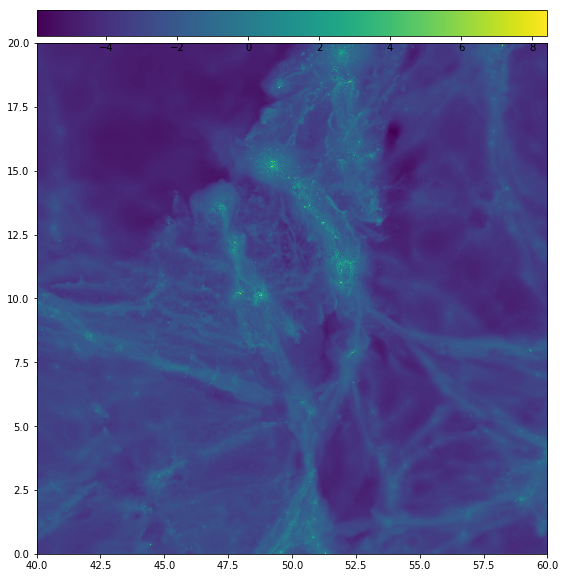

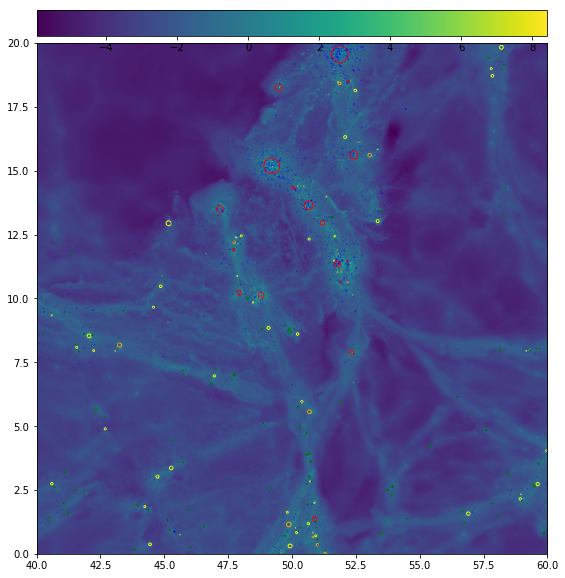

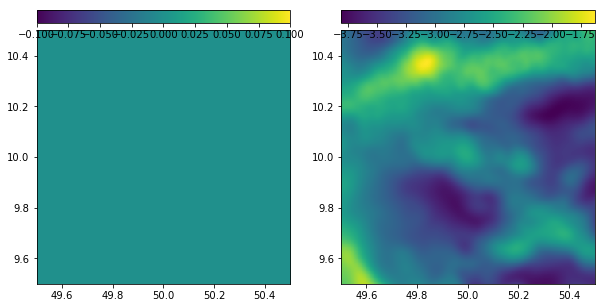

In [8]:
masked_data = maskgalaxies(data_cutout,xystarts,size,slicewidth,distance,resolution,debug=False,verbose=False)

### extract the filament (both data and mask)

cutout is supplied - will extract filament from the cutout.
The type of size is <type 'float'>
Region 1: [ 2528.  2144.  2368.  2752.] , [ 3360.  4480.  4480.  3360.]
xacross_length,yacross_length,xdown_length,ydown_length:  223, 0, -383, 1120
xacross_length > yacross_length:
iterable: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

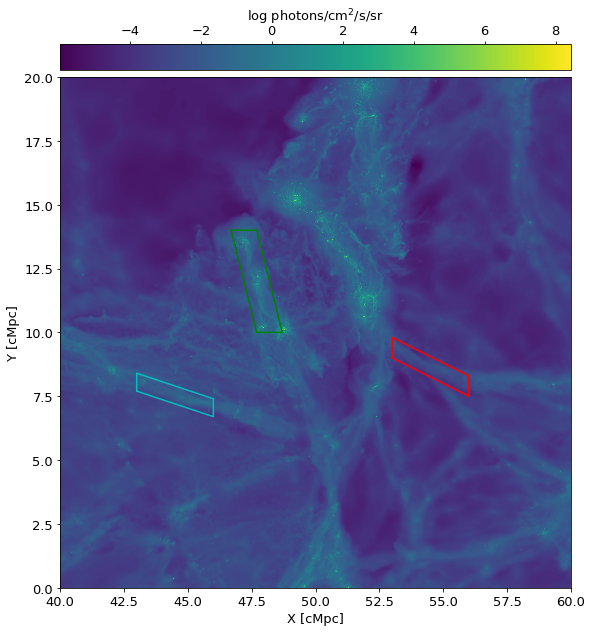

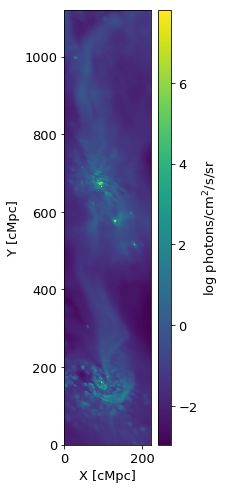

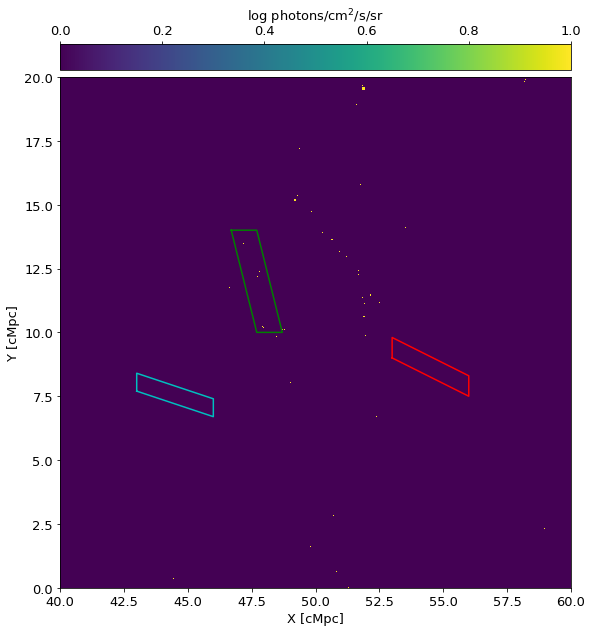

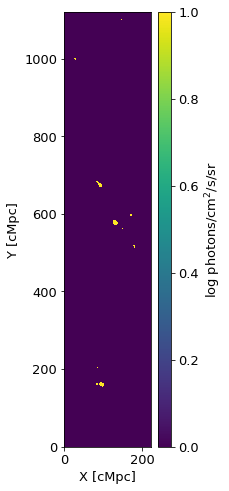

In [9]:
SBdata_cutout = extractfilament(cutout=masked_data.data,plotchecks=True)
mask_cutout = extractfilament(cutout=masked_data.mask,plotchecks=True)

### add the noise

In [10]:
exptime = 60.*60.*1000.
filterwidth = 1
CMOS = True
ROnoise = None
includemeannoise = True

******* Adding noise to the input data to simulate a mock observation by the 48.0 lens Dragonfly Telescope *******
DEBUGGING: the binpix_size (resolution) is 13.0357429643
DEBUGGING: the pixel size (inherent) is 2.8
VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)
DEBUGGING: R is : 2.0
DEBUGGING: the number of pixels per bin is 25.0
DEBUGGING: raise the data by 10** since was logged data before...
DEBUGGING: the total object signal [electrons] detected ranges from: 0.0836691540048 to 4861289910.28
The width of the filter that the data was taken with is 1 nm. 
DEBUGGING: Sky background in filter width of 1 nm is calculated already: 0.560633.
Adding sky background noise and shot noise...
DEBUGGING: the background in the bandwidth is: 0.560633 photon/s/arcsec^2/m^2
DEBUGGING: the background signal, B_sky, is: 2.01611304518 electron/s/pixel
DEBUGGING: the mean total background signal, B_sky_total [electrons], is: 181450174.066
DEBUGGING: the total background noisy signal [electrons] 

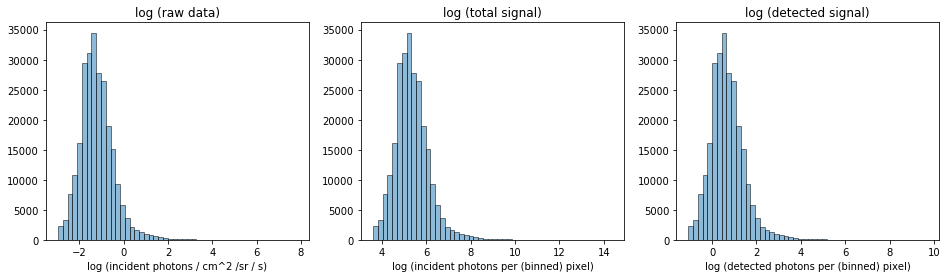

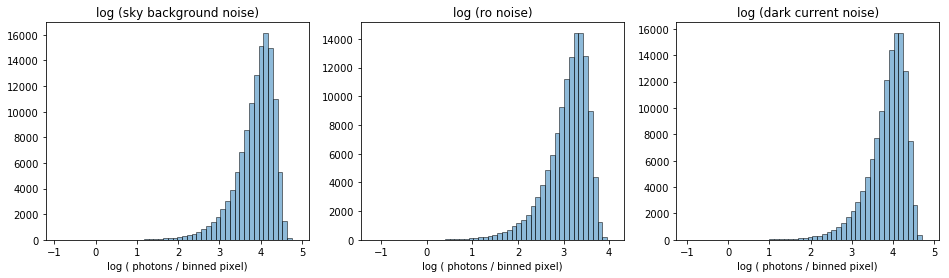

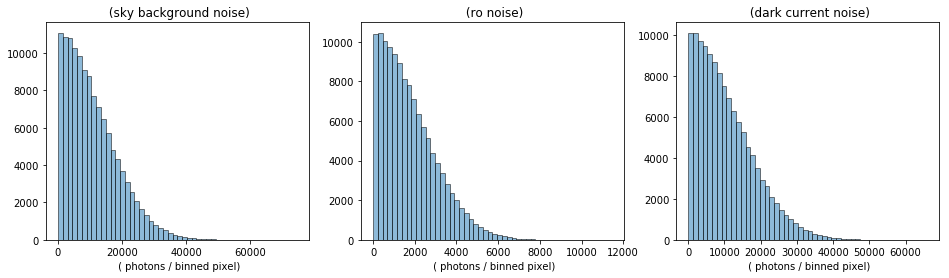

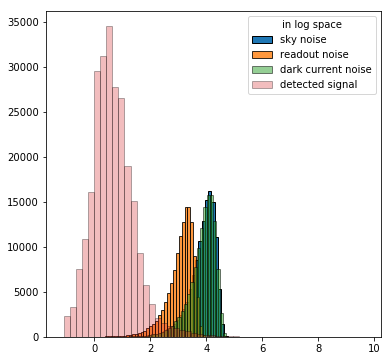

In [11]:
noiseadded_signal,B_sky_array,R_array,D_array = addnoise(SBdata_cutout,resolution,exptime=exptime,filterwidth=filterwidth,\
                                                         CMOS=CMOS,R=ROnoise,debugging=True,includemeannoise=includemeannoise,\
                                                         plotchecks=plotchecks)

#### plotting scripts

In [12]:
def plotfilamentnice(SBdata_exp0,ax,mymap='gist_gray',label=''):
    # Plot the data nicely
    median = np.median(SBdata_exp0);
    sig = np.sqrt(median)

    mymax = median + 40*sig
    mymin = median - 5*sig

    SBdata_clipped = SBdata_exp0 + 0
    SBdata_clipped[SBdata_clipped < mymin] = mymin
    SBdata_clipped[SBdata_clipped > mymax] = mymax
    SBdata_clipped = SBdata_clipped - mymin
    
    get_halpha_SB.makemapfilament(np.log10(SBdata_clipped**0.5),ax,contours=False,mockobs=True,\
                                  colmap=mymap,label=label,labelaxes=True)

def plotdata(data,ax=None,bounds=None,colorbar=False,colmap='viridis'):
    """
    General use plotting of image
    """
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
    if bounds is None:
        img = ax.imshow(data,origin='lower',cmap=cm.get_cmap(colmap),interpolation='nearest')
    else:
        img = ax.imshow(data,origin='lower',cmap=cm.get_cmap(colmap),vmin=bounds[0],vmax=bounds[1],interpolation='nearest')
    ax.set_aspect('equal')
    
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    ax.patch.set_facecolor('black')
    
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("right",size="10%",pad=0.15)
        cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
        cbar.ax.tick_params()


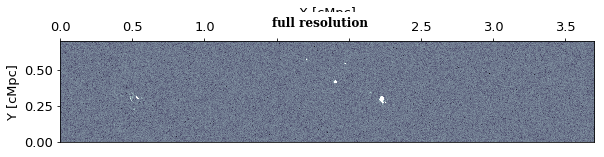

In [13]:
### EXAMPLE PLOT OF THE FULL RESOLUTION NOISE-ADDED FILAMENT

fig,(ax1) = plt.subplots(1,1,figsize = (8.5, 7.))
map = 'bone'; label = 'full resolution'; 
plotfilamentnice(noiseadded_signal,ax1,mymap=map,label=label)


### bin the data (using the mask)

To get to 100" resolution, use factor of 8 (matches what did before).<br>
Using the 'sum' method of binning  (rather than taking average - this just makes the plotting easier since don't have to play around with the mymin and mymax limits).

In [35]:
%run 'mask_galaxies.ipynb'

#### without mask

Will set mask to False since masking is set to False.
Output grid must have a integer number of cells: trimming the array down to satisfy this.
Before reducing resolution, the original array was trimmed from size 1121,224 to size 1120,224.
Before reducing resolution, the original array was trimmed from size 1121,224 to size 1120,224.
take the sum along different axes


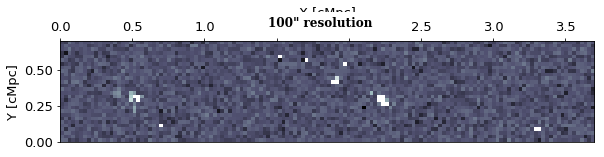

In [30]:
factor=8
noiseadded_100,mask_none,fill_none=imreduce_masked(noiseadded_signal,factor,log=False,masking=False,method='sum')

### EXAMPLE PLOT OF THE 100 arcsec RESOLUTION NOISE-ADDED FILAMENT (WITHOUT MASKING)

fig,(ax1) = plt.subplots(1,1,figsize = (8.5, 7.))
map = 'bone'; label='100" resolution';
plotfilamentnice(noiseadded_100,ax1,mymap=map,label=label)


#### with mask

Need to use 'average' method in this case (because if have masked regions this takes care of that correctly).
Make plotting work by multiplying the output array by factor^2 - since this effectively brings it back to 'sum'.

Output grid must have a integer number of cells: trimming the array down to satisfy this.
Before reducing resolution, the original array was trimmed from size 1121,224 to size 1120,224.
Before reducing resolution, the original array was trimmed from size 1121,224 to size 1120,224.
take the mean along different axes
(140, 28)
(140, 28)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


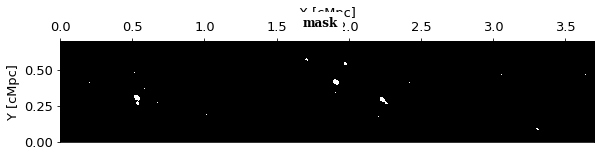

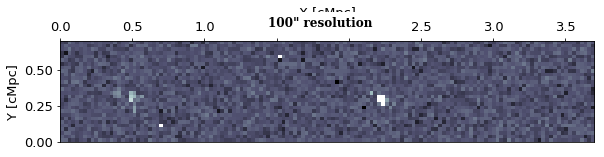

In [36]:
factor=8
noiseadded_masked_100,mask_100,fill_100=imreduce_masked(noiseadded_signal,factor,mask=mask_cutout,log=False,masking=True,method='average')

fig,(ax1) = plt.subplots(1,1,figsize = (8.5, 7.))
map = 'bone'; label='mask';
get_halpha_SB.makemapfilament(mask_cutout,ax1,colmap=map,label=label,labelaxes=True)

fig,(ax1) = plt.subplots(1,1,figsize = (8.5, 7.))
map = 'bone'; label='100" resolution';
plotfilamentnice(noiseadded_masked_100*factor**2,ax1,mymap=map,label=label)